# 0. Basics
* Problematica
    * Nos comentan que existe una crisis de rotacion de personal
    * Reducir la fuga de empleados
    * Perdida de empleado, talento y costos de reemplazo
* Objetivos
    * Entender y cuantificar el problema desde el punto de vista de negocio
    * Desarrollar un sistema automatizado de machine learning que identifique a los empleados que están en mayor riesgo de fuga 
    * Comunicar los resultados de forma exitosa a la dirección
* Estructura del proyecto
    * Business Analytics
    * Machine learning

# 1. Preparación del proyecto

## Librerias

In [105]:
import numpy as np
import pandas as pd
# import matplotlib.pyplot as plt
# %matplotlib inline
import plotly.express as px

## Carga de datos

In [106]:
df = pd.read_csv('AbandonoEmpleados.csv', sep = ';', index_col= 'id', na_values='#N/D')
df.sample(3)

,edad,abandono,viajes,departamento,distancia_casa,educacion,carrera,empleados,satisfaccion_entorno,sexo,...,satisfaccion_companeros,horas_quincena,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,conciliacion,anos_compania,anos_en_puesto,anos_desde_ult_promocion,anos_con_manager_actual
id,,,,,,,,,,,,,,,,,,,,,
807,40,No,Travel_Frequently,Research & Development,2,Master,Medical,1,Alta,4.0,...,Muy_Alta,80,1,8,2,Muy_Alta,8,NaN,3,7
1116,48,No,Non-Travel,Research & Development,1,Master,Medical,1,Baja,4.0,...,Alta,80,0,27,3,NaN,5,NaN,2,1
1024,48,No,Travel_Rarely,Research & Development,4,Secundaria,Life Sciences,1,Alta,2.0,...,Media,80,0,27,3,NaN,15,NaN,4,8


# 2. Business Analytics

## Limpieza de datos

In [107]:
# Revisamos que datos tenemos y el tipo de cada uno
print('La forma de nuestro database ', 
      df.shape[1], 'columnas y ',
      df.shape[0], ' filas')
df.info()

La forma de nuestro database  31 columnas y  1470  filas
<class 'pandas.core.frame.DataFrame'>
Index: 1470 entries, 1 to 2068
Data columns (total 31 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   edad                      1470 non-null   int64  
 1   abandono                  1470 non-null   object 
 2   viajes                    1470 non-null   object 
 3   departamento              1470 non-null   object 
 4   distancia_casa            1470 non-null   int64  
 5   educacion                 1369 non-null   object 
 6   carrera                   1470 non-null   object 
 7   empleados                 1470 non-null   int64  
 8   satisfaccion_entorno      1470 non-null   object 
 9   sexo                      1271 non-null   float64
 10  implicacion               1452 non-null   object 
 11  nivel_laboral             1470 non-null   int64  
 12  puesto                    1470 non-null   object 
 13  satisfaccio

### Variables con valores unicos
* Podemos eliminar estas variables ya que no aportan informacion por tener un solo valor
* Analizando si hay variables con valores unicos de los que podemos prescindir

In [108]:
# lista de variables que tienen un valor unico
for i in df.columns:
    unicos = len(df[i].unique())
    if unicos==1:
        print(i)

# eliminamos las variables
df_clean = df.drop(['empleados', 'mayor_edad', 'horas_quincena'], axis=1)

empleados
mayor_edad
horas_quincena


### Valores vacios
* Encontremos columnas con algunas variables vacias
* Se ven mas de 50% valores faltantes en anos_en_puesto y conciliacion -> numero de valores nulos extramandamente altos que no pueden ser supuestos y podrian ser muy costodo volver a solicitar su recoleccion
* Valores faltantes mas de 10% en sexo -> adiferencia de algunos casos comunes esta abse ha considerado mas de dos opciones en su encuesta de sexo, lo que complica un poco el rellenando del valos faltante. Un 13% de valores podria no considerarse alto. Si definimos que es una variable impotane para el negocio entonces ayudaria mucho conocer esos valores nulos. Ahora para encontrar esos valores, podemos rehacer la encuesta para esos IDs, podriamos basarnos en el nombre de las personas y asignarles una sexo (podria existir erroes o sesgo pero la falla seria poca), o podriamos asignarle un valor que mantenga la misma distribucion en los datos de variables que  se relacionan, o simplemente podriamos no considerarla
* Otros valores faltantes pequenos en porcentaje son educacion, satisfaccion_trabajo, implicacion, para cada imputacion de datos por cada varaibles se hara un proceso diferente que depende de cada caso

In [109]:
# df.sexo.unique()
df.educacion.value_counts(dropna=False)


educacion
Universitaria    814
Secundaria       348
Master           130
NaN              101
Primaria          77
Name: count, dtype: int64

In [110]:
# porcentaje de valores faltantes
print((df_clean.isnull().sum().sort_values(ascending=False)/df_clean.shape[0])*100)

# eliminar columnas >50%
df_clean = df_clean.drop(['anos_en_puesto', 'conciliacion'], axis=1)


anos_en_puesto              84.217687
conciliacion                68.775510
sexo                        13.537415
educacion                    6.870748
satisfaccion_trabajo         5.170068
implicacion                  1.224490
edad                         0.000000
horas_extra                  0.000000
anos_desde_ult_promocion     0.000000
anos_compania                0.000000
num_formaciones_ult_ano      0.000000
anos_experiencia             0.000000
nivel_acciones               0.000000
satisfaccion_companeros      0.000000
evaluacion                   0.000000
incremento_salario_porc      0.000000
salario_mes                  0.000000
num_empresas_anteriores      0.000000
abandono                     0.000000
estado_civil                 0.000000
puesto                       0.000000
nivel_laboral                0.000000
satisfaccion_entorno         0.000000
carrera                      0.000000
distancia_casa               0.000000
departamento                 0.000000
viajes      

#### Para a variable sexo
* Analizamos la frecuencia de valores en la variable sexo, en %
* el 13% de todos los valores es nulo, sin embargo, dependiento del negocio la fuerza laboral normalmente tiene una compocions de 50 50 entre hombres y mujeres y para otras opciones tomadas en la encuesta son porcentaje minimos. Sin embargo para este caso no se encontraron ditrbuciones orientadas a dos valores, lo que haria dudar mucho de la fiabilidad de la data y que este 13% de valores nulos probablemente sean solo de una valor. Por eso, se debe indagar mas en el resto de datos que tenemos.
* Vamos a ponerle dos asumiendo que 3 es fem y 2 masc y debe haber una relacion cerca al 50% entre F y M

In [111]:
# Analizando la variable sexo
print(df_clean.sexo.value_counts(dropna=False, sort=True)/df_clean.sexo.shape[0])

# No se hace hasta que se pamos con vealor vamos a reemplazar
df_clean['sexo'] = df_clean['sexo'].fillna(2)

sexo
3.0    0.502721
2.0    0.223129
NaN    0.135374
4.0    0.088435
1.0    0.050340
Name: count, dtype: float64


* Nos basamos en la variable salario_mes 
* reemplazamos los nulos de implicacion segun la media


In [112]:
# media de salario_mes por implicacion
print(df_clean.groupby(['implicacion']).agg(n=('salario_mes','median')))

# reemplazmos los na de implicacion
df_clean.loc[(df_clean['salario_mes'] > 5346.0) & (df_clean['implicacion'].isna()), 'implicacion'] = 'Baja'
df_clean.loc[(df_clean['salario_mes'].between(5146.5, 5346.0)) & (df_clean['implicacion'].isna()), 'implicacion'] = 'Media'
df_clean.loc[(df_clean['salario_mes'].between(4779.0, 5146.5)) & (df_clean['implicacion'].isna()), 'implicacion'] = 'Alta'
df_clean.loc[(df_clean['salario_mes'] < 4779.0) & (df_clean['implicacion'].isna()), 'implicacion'] = 'Muy_Alta'

                  n
implicacion        
Alta         4779.0
Baja         5346.0
Media        5146.5
Muy_Alta     4888.0


* Anaizamos la variable educacion y su relacion con implicacion
* Encontramos una relacion directa entre estas dos variables
* Nos ayudamos de la variable implicacion para rellenar la variable educacion

In [113]:
# Contrando la fecuencia de educacion e implicacion
print(
    df_clean.groupby(['educacion', 'implicacion']).agg(n=('implicacion','count'))
    )

# Rellenando los Na
mapeo_implicacion = {'Muy_Alta':'Master', 'Alta': 'Universitaria', 
                     'Media': 'Secundaria', 'Baja': 'Primaria'}

df_clean['educacion'] = df_clean.apply(lambda row: 
                                 mapeo_implicacion[row['implicacion']] 
                                 if pd.isna(row['educacion']) else row['educacion'], 
                                 axis=1)

                             n
educacion     implicacion     
Master        Muy_Alta     130
Primaria      Baja          77
Secundaria    Media        348
Universitaria Alta         814


* Analizando satisfaccion_trabajo
* Encontramos una relacion directa entre la implicacion y satisfaccion

In [114]:
# Contrando la fecuencia de educacion e implicacion
print(
    df_clean.groupby(['satisfaccion_trabajo', 'implicacion']).agg(n=('implicacion','count'))
    )

# reemplazando
df_clean['satisfaccion_trabajo'] = df_clean['implicacion']

                                    n
satisfaccion_trabajo implicacion     
Alta                 Alta         828
Baja                 Baja          76
Media                Media        354
Muy_Alta             Muy_Alta     136


In [115]:
# revision de valores nulos
print(df_clean.isnull().sum().sort_values(ascending=False))

edad                        0
abandono                    0
anos_desde_ult_promocion    0
anos_compania               0
num_formaciones_ult_ano     0
anos_experiencia            0
nivel_acciones              0
satisfaccion_companeros     0
evaluacion                  0
incremento_salario_porc     0
horas_extra                 0
num_empresas_anteriores     0
salario_mes                 0
estado_civil                0
satisfaccion_trabajo        0
puesto                      0
nivel_laboral               0
implicacion                 0
sexo                        0
satisfaccion_entorno        0
carrera                     0
educacion                   0
distancia_casa              0
departamento                0
viajes                      0
anos_con_manager_actual     0
dtype: int64


In [116]:
# cambiar los tipos de dato y agruparlos segun mi interes

df_clean['sexo'] = df_clean['sexo'].astype('object')

# abanadono es la variable a predecir abandono
ordinales = ['satisfaccion_entorno', 'implicacion',
            'satisfaccion_trabajo', 'satisfaccion_companeros', 'evaluacion']
categoricas = ['viajes', 'departamento', 'carrera', 'sexo',
               'puesto', 'estado_civil', 'horas_extra', 'educacion']
numericas = ['edad','distancia_casa', 'nivel_laboral', 'salario_mes',
             'num_empresas_anteriores', 'incremento_salario_porc',
             'nivel_acciones', 'anos_experiencia','num_formaciones_ult_ano',
             'anos_compania', 'anos_desde_ult_promocion', 'anos_con_manager_actual'] 

## EDA

### Categoricas

In [117]:
# defino colores para el grafico
colores = {'No': 'grey', 'Yes': 'lightcoral'}

* Viajes: Los viajeros frecuentes renuncian mas, pero tambien podria deberse al puesto, si existe el mismo puesto pero sin viajes y tiene menor rotacion, la motivacion de renunciar seria solo por los viajes
* Departamento:  el abandono no es diferencial entre departamentos, Ventas es el que mas diferencia tiene
* Carrera: empleados con una carrera en tech, HR y Mkt son los que mas renuncian, habría que ver que relación tienen estas carreras con el puesto o con la frecuencia de viajes
* Sexo: El mas alto es 1 que no sabemos a que hace referencia, podríamos suponer si es sexo no binario que la rotación puede ser alta por falta de políticas inclusivas, seria importante saber si eso pasa con alguna area en especifico
* Puesto: Los representantes de ventas tienen alta rotación, validar si esto son los que viajan. Areas de técnico e laboratorio y HR. Tambien validar si estas carreras son parte de una alta demanda en el mercado y necesitamos benéficos mas atractivos.
* Estado civil: solteros, probablemente por no tener cargas
* HX: si tiene horas puedes ser por el puesto departamento, incluso por el estado civil 
* Educación: Educación primaria mayor rotación, el puesto debe ser un puesto de alta rotación sin importancia en educación sino en experiencia

In [118]:
for i in categoricas:
   fig = px.bar((df_clean
                  .groupby([i, 'abandono'], as_index=False)
                  .agg(n=('abandono', 'count'))
                  .assign(porcentaje = lambda d: round(d['n'] / d.groupby(i)['n'].transform('sum'),2))),
               x='porcentaje', y=i,
               color='abandono',
               color_discrete_map=colores,
               barmode='stack',
               height=300, width=500,
               text_auto=True,
               hover_data={'n': True})
               
   fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
   fig.update_layout(title=f"Abandono por {i}") 

   fig.show()

### Ordinales

* Satisfacción: hay que ver con el departamento o el puesto si es que la satisfacción es baja
* Evaluación: no tiene nada que ver

In [119]:
for i in ordinales:
   fig = px.bar((df_clean
                  .groupby([i, 'abandono'], as_index=False)
                  .agg(n=('abandono', 'count'))
                  .assign(p = lambda d: round(d['n'] / d.groupby(i)['n'].transform('sum'),2))),
               x='p', y=i,
               color='abandono', 
               color_discrete_map=colores,
               barmode='stack',
               category_orders={i:['Muy_Alta', 'Alta', 'Media', 'Baja']},
               height=300, width=600,
               text_auto=True)
   fig.show()

### Numericas

* Edad: jovenes renuncian mas, esto puede ir de la mano con EC
* Distancia casa: mayor distancia promedio mayor cese
* Nivel laboral: mayores renuncias en menor nivel que epuede ir a la mano con edad, puesto y educacion
* Salario: nivel laboral, edad, puesto y educación
* empresas anteriores: tienen menos empresas anteriores renuncian mas, se puede deber a la edad
* incremento de salario: no es importante
* experiencia: menos anos de experiencia mayor abandono, puede deberse a la edad
* Antigüedad empresa: menos anios en la empresa, mayor cese, puede ser por la edad (igual que anios con manager antual)

In [120]:
for i in numericas:
   fig = px.box(df_clean,
               x=i, y='abandono',
               color='abandono', 
               color_discrete_map=colores,
               height=300, width=600,
               # text_auto=True
               )
   fig.show()

## Generar insights
* Surgen de las preguntas y dudas que optuve en la parte anterior (Preguntas semilla de conocimiento de negocio)
* Nos toca asumir que la rotacion es voluntaria (no consideramos despidos)

In [121]:
# Rotacion global
(df_clean
 .groupby(['abandono'], as_index=False)
 .agg(n=('abandono', 'count'))
 .assign(p = lambda d: round(d.n/d['n'].sum() ,2))
)

,abandono,n,p
0,No,1233,0.84
1,Yes,237,0.16


* El departamento de venta es el qu tiene mas rotacion, el HR tambien pero el numero de empleados es menor por lo que el % de rotacion es mas facil de impactar
* Dentro de ventas, los represenantes de ventas son los de mayor rotacion


In [122]:
# Rotacion por departamentos
print('departamentos:', df_clean.departamento.unique())

(df_clean
 .groupby(['abandono', 'departamento'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='departamento',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)



departamentos: ['Sales' 'Research & Development' 'Human Resources']


abandono,No,Yes,p
departamento,,,
Human Resources,51.0,12.0,0.19
Research & Development,828.0,133.0,0.14
Sales,354.0,92.0,0.21


In [123]:
# Rotacion por puestosdel departamento de Sales

(df_clean
 .query('departamento == "Sales"')
 .groupby(['abandono', 'puesto'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='puesto',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)

abandono,No,Yes,p
puesto,,,
Manager,35.0,2.0,0.05
Sales Executive,269.0,57.0,0.17
Sales Representative,50.0,33.0,0.40


* Los representantes de ventas que viajan mas son los que mas renuncian? - si

In [124]:
(df_clean
 .query('departamento == "Sales" & puesto == "Sales Representative"')
 .groupby(['abandono', 'viajes'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='viajes',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)

abandono,No,Yes,p
viajes,,,
Non-Travel,5.0,NaN,NaN
Travel_Frequently,8.0,15.0,0.65
Travel_Rarely,37.0,18.0,0.33


In [125]:
fig = px.bar((df_clean
                .query('departamento == "Sales" & puesto == "Sales Representative"')
                .groupby(['viajes', 'abandono'], as_index=False)
                .agg(n=('abandono', 'count'))
                .assign(porcentaje = lambda d: round(d['n'] / d.groupby('viajes')['n'].transform('sum'),2))),
            x='porcentaje', y='viajes',
            color='abandono',
            color_discrete_map=colores,
            barmode='stack',
            height=300, width=500,
            text_auto=True,
            hover_data={'n': True})
            
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.update_layout(title=f"Abandono por viaje de Sales Representative") 

fig.show()

* Los preresentantes de ventas que dejan el trabajo con los que estudiaron mkt y grado tecnico, o talvez las funciones del puesto no calzan con los skills del empleado qu estudio mkt y grado tecnico

In [126]:
(df_clean
 .query('departamento == "Sales" & puesto == "Sales Representative"')
 .groupby(['abandono', 'carrera'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='carrera',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)   

abandono,No,Yes,p
carrera,,,
Life Sciences,18.0,9.0,0.33
Marketing,11.0,12.0,0.52
Medical,13.0,5.0,0.28
Other,1.0,1.0,0.50
Technical Degree,7.0,6.0,0.46


In [127]:
fig = px.bar((df_clean
                .query('departamento == "Sales" & puesto == "Sales Representative"')
                .groupby(['carrera', 'abandono'], as_index=False)
                .agg(n=('abandono', 'count'))
                .assign(porcentaje = lambda d: round(d['n'] / d.groupby('carrera')['n'].transform('sum'),2))),
            x='porcentaje', y='carrera',
            color='abandono',
            color_discrete_map=colores,
            barmode='stack',
            height=300, width=500,
            text_auto=True,
            hover_data={'n': True})
            
fig.update_layout(legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1))
fig.update_layout(title=f"Abandono por carrera de Sales Representative") 

fig.show()

In [128]:
fig = px.box((df_clean
              .query('departamento == "Sales" & puesto == "Sales Representative"')
              .sort_values('carrera')),
               x='salario_mes', color='abandono',
               y='carrera', 
               color_discrete_map=colores,
               height=500, width=600,
               
               )
fig.show()

* El sexo del vendedor influye en algo?

In [129]:
(df_clean
#  .query('departamento == "Sales" & puesto == "Sales Representative"')
 .query('departamento == "Sales"')
 .groupby(['abandono', 'sexo'], as_index=False)
 .agg(n=('abandono', 'count'))
 .pivot_table(index='sexo',
              columns='abandono',
              values='n')
 .assign(p = lambda d: round(d['Yes']/(d['Yes']+d['No']) ,2))
)

abandono,No,Yes,p
sexo,,,
1.0,12.0,13.0,0.52
2.0,127.0,34.0,0.21
3.0,190.0,39.0,0.17
4.0,25.0,6.0,0.19


* Los que se van de educacion primaria quienes son?

In [130]:
fig = px.bar((df_clean
            #   .query('departamento == "Sales"')
              # .query('departamento == "Sales" & puesto == "Sales Representative"')
              .groupby(['departamento', 'educacion'], as_index=False)
              .agg(n=('departamento', 'count'))
              .assign(p = lambda d: round(d['n'] / d.groupby('educacion')['n'].transform('sum'),2))
              .sort_values('educacion')
              ),
               x='p', y='educacion',
               color='departamento', 
               color_discrete_map=colores,
               barmode='stack',
               height=300, width=600,
               text_auto=True,
               hover_data={'n': True})


fig.show()

* Que departamento tiene menor satisfaccion ?
* satisfaccion_entorno: similar en todos
* implicacion: la mas baja esta dentro de ventas, se reduce muy alta. El manager tiene mas baja
* satisfaccion_trabajo: similar en todos
* satisfaccion_companeros: en ventas es menor y losque tienen menos son los ejecutivos de ventas
* evaluacion: similar en todos

In [131]:
fig = px.bar((df_clean
              .groupby(['implicacion', 'departamento'], as_index=False)
              .agg(n=('implicacion', 'count'))
              .assign(p = lambda d: round(d['n'] / d.groupby('departamento')['n'].transform('sum'),2))
              ),
               x='p', y='departamento',
               color='implicacion', 
               color_discrete_map=colores,
               barmode='stack',
               height=300, width=600,
               text_auto=True,
               hover_data={'n': True},
               category_orders={'implicacion': ['Muy_Alta', 'Alta', 'Media', 'Baja']})

fig.update_layout(title=f"Implicacion por departamento") 
fig.show()

In [132]:
fig = px.bar((df_clean
              .groupby(['satisfaccion_companeros', 'departamento'], as_index=False)
              .agg(n=('satisfaccion_companeros', 'count'))
              .assign(p = lambda d: round(d['n'] / d.groupby('departamento')['n'].transform('sum'),2))
              ),
               x='p', y='departamento',
               color='satisfaccion_companeros', 
               color_discrete_map=colores,
               barmode='stack',
               height=300, width=600,
               text_auto=True,
               hover_data={'n': True},
               category_orders={'satisfaccion_companeros': ['Muy_Alta', 'Alta', 'Media', 'Baja']})

fig.update_layout(title=f"Satisfaccion de compañeros por departamento") 
fig.show()

In [133]:
fig = px.bar((df_clean
              .query('departamento == "Sales"')
              .groupby(['puesto', 'satisfaccion_companeros'], as_index=False)
              .agg(n=('puesto', 'count'))
              .assign(p = lambda d: round(d['n'] / d.groupby('satisfaccion_companeros')['n'].transform('sum'),2))
              ),
               x='p', y='satisfaccion_companeros',
               color='puesto', 
               barmode='stack',
               height=300, width=600,
               text_auto=True,
               hover_data={'n': True})
fig.show()

* Existe diferencia en la edad promedio por departamento o puesto

In [134]:
fig = px.box((df_clean
            #   .query('departamento == "Sales"')
              .sort_values('puesto')),
               x='edad', y='abandono',
               color='puesto', 
               color_discrete_map=colores,
               height=500, width=600,
               
               )
fig.show()

In [135]:
# edad vs salario

fig = px.scatter(df_clean, 
                 x='edad', y='salario_mes', 
                 color='abandono',
                 title=' edad vs salario', 
                #  labels={'x': 'Eje X', 'y': 'Eje Y'},
                #  hover_data=['otra_columna']
                color_discrete_map=colores,
                height=500, width=600,
                 )
fig.show()

# 3. Preparación para el modelo

## Posibles colinealidades

* El salario siempre va ir en una banda salarial acorde al nivel laboral, por lo que me dan la misma infomacion, para esto decido eliminar nivel laboral

In [136]:
# df_clean[numericas][
df_clean[numericas].corr()[(df_clean[numericas].corr()>0.7) | (df_clean[numericas].corr()>=1)].dropna(how='all')
# ].dropna()

,edad,distancia_casa,nivel_laboral,salario_mes,num_empresas_anteriores,incremento_salario_porc,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,anos_compania,anos_desde_ult_promocion,anos_con_manager_actual
edad,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distancia_casa,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
nivel_laboral,NaN,NaN,1.000000,0.950300,NaN,NaN,NaN,0.782208,NaN,NaN,NaN,NaN
salario_mes,NaN,NaN,0.950300,1.000000,NaN,NaN,NaN,0.772893,NaN,NaN,NaN,NaN
num_empresas_anteriores,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
incremento_salario_porc,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
nivel_acciones,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
anos_experiencia,NaN,NaN,0.782208,0.772893,NaN,NaN,NaN,1.000000,NaN,NaN,NaN,NaN
num_formaciones_ult_ano,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN
anos_compania,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,0.769212


In [137]:
import plotly.figure_factory as ff

# corr_matrix = df_clean[numericas].corr()
corr_matrix = df_clean[numericas].corr()[(df_clean[numericas].corr()>0.7) | (df_clean[numericas].corr()>=1)].dropna(how='all')

fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    annotation_text=corr_matrix.round(2).values,
    showscale=True,
    colorscale='twilight'
)
# 'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',         'turbo', 'twilight', '
fig.show()

In [138]:
import plotly.figure_factory as ff

# corr_matrix = df_clean[numericas].corr()
corr_matrix = df_clean[numericas].corr()

fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    annotation_text=corr_matrix.round(2).values,
    showscale=True,
    colorscale='tempo'
)
# 'tealrose', 'tempo', 'temps', 'thermal', 'tropic', 'turbid',   'turbo', 'twilight', '
fig.show()

In [139]:
from scipy import stats

resultados = {}
for col in numericas:
    stat, p = stats.shapiro(df_clean[col])
    resultados[col] = (stat, p)
    print(f'Columna: {col}, Estadístico=%.3f, p=%.3f' % (stat, p))
    if p > 0.05:
        print(f'La muestra de la columna {col} parece provenir de una distribución normal (no se rechaza H0)')
    else:
        print(f'La muestra de la columna {col} no parece provenir de una distribución normal (se rechaza H0)')

# Mostrar los resultados
print(resultados)

Columna: edad, Estadístico=0.977, p=0.000
La muestra de la columna edad no parece provenir de una distribución normal (se rechaza H0)
Columna: distancia_casa, Estadístico=0.862, p=0.000
La muestra de la columna distancia_casa no parece provenir de una distribución normal (se rechaza H0)
Columna: nivel_laboral, Estadístico=0.822, p=0.000
La muestra de la columna nivel_laboral no parece provenir de una distribución normal (se rechaza H0)
Columna: salario_mes, Estadístico=0.828, p=0.000
La muestra de la columna salario_mes no parece provenir de una distribución normal (se rechaza H0)
Columna: num_empresas_anteriores, Estadístico=0.849, p=0.000
La muestra de la columna num_empresas_anteriores no parece provenir de una distribución normal (se rechaza H0)
Columna: incremento_salario_porc, Estadístico=0.901, p=0.000
La muestra de la columna incremento_salario_porc no parece provenir de una distribución normal (se rechaza H0)
Columna: nivel_acciones, Estadístico=0.790, p=0.000
La muestra de la

In [140]:
# sns.pairplot(df_clean[numericas], kind='scatter', diag_kind='kde', markers='+', plot_kws={'alpha':0.5})

In [141]:
# eliminamos columna con la misma informacion
df_clean = df_clean.drop(columns='nivel_laboral')
# df_clean = df_clean.drop(columns='nivel_laboral')

In [142]:
import seaborn as sns

## Encoding de las variables no numericas

In [143]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder

In [144]:
df_encoded_cat = df_clean[categoricas].copy()
for i in categoricas:
    encoder = OneHotEncoder(drop='first')
    encoded_data = encoder.fit_transform(df_clean[[i]]).toarray()
    encoded_df = (pd.DataFrame(encoded_data, 
                          columns=encoder.get_feature_names_out([i])
                          ).reset_index(drop=True))
    df_encoded_cat = pd.concat([df_encoded_cat.reset_index(drop=True), 
                                encoded_df], 
                                axis=1).drop(columns=[i])

df_encoded_cat

,viajes_Travel_Frequently,viajes_Travel_Rarely,departamento_Research & Development,departamento_Sales,carrera_Life Sciences,carrera_Marketing,carrera_Medical,carrera_Other,carrera_Technical Degree,sexo_2.0,...,puesto_Research Director,puesto_Research Scientist,puesto_Sales Executive,puesto_Sales Representative,estado_civil_Married,estado_civil_Single,horas_extra_Yes,educacion_Primaria,educacion_Secundaria,educacion_Universitaria
0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
4,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1465,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1466,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1467,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1468,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [145]:
# transformar ordinales a numericos
df_encoded_ord = df_clean[ordinales].copy()
orden = ['Muy_Alta', 'Alta', 'Media', 'Baja']
for i in ordinales:
    encoded_ord = OrdinalEncoder(categories=[orden]).fit_transform(df_clean[[i]])
    df_encoded_ord[i] = encoded_ord.flatten()
    df_encoded_ord.reset_index(drop=True, inplace=True)
# validamos

df_encoded_ord


,satisfaccion_entorno,implicacion,satisfaccion_trabajo,satisfaccion_companeros,evaluacion
0,2.0,1.0,1.0,3.0,1.0
1,1.0,2.0,2.0,0.0,0.0
2,0.0,2.0,2.0,2.0,1.0
3,0.0,1.0,1.0,1.0,1.0
4,3.0,1.0,1.0,0.0,1.0
...,...,...,...,...,...
1465,1.0,0.0,0.0,1.0,1.0
1466,0.0,2.0,2.0,3.0,1.0
1467,2.0,0.0,0.0,2.0,0.0
1468,0.0,2.0,2.0,0.0,1.0


In [146]:
df_encoded_num = df_clean[['edad','distancia_casa', 'salario_mes', 'num_empresas_anteriores', 'incremento_salario_porc',
             'nivel_acciones', 'anos_experiencia','num_formaciones_ult_ano',
             'anos_compania', 'anos_desde_ult_promocion', 'anos_con_manager_actual']].reset_index(drop=True)
df_encoded_num

,edad,distancia_casa,salario_mes,num_empresas_anteriores,incremento_salario_porc,nivel_acciones,anos_experiencia,num_formaciones_ult_ano,anos_compania,anos_desde_ult_promocion,anos_con_manager_actual
0,41,1,5993,8,11,0,8,0,6,0,5
1,49,8,5130,1,23,1,10,3,10,1,7
2,37,2,2090,6,15,0,7,3,0,0,0
3,33,3,2909,1,11,0,8,3,8,3,0
4,27,2,3468,9,12,1,6,3,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
1465,36,23,2571,4,17,1,17,3,5,0,3
1466,39,6,9991,4,15,1,9,5,7,1,7
1467,27,4,6142,1,20,1,6,0,6,0,3
1468,49,2,5390,2,14,0,17,3,9,0,8


In [147]:
abandono = df_clean['abandono'].map({'Yes': 1, 'No': 0}).reset_index(drop=True)

In [148]:
df_encoded = pd.concat([df_encoded_num, df_encoded_cat, df_encoded_ord, abandono], axis=1)

In [149]:
df_encoded['abandono'].value_counts()#/df_encoded.shape[0]

abandono
0    1233
1     237
Name: count, dtype: int64

# 5. Modelado

In [150]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import MinMaxScaler


## 5.1 Particion

In [198]:
X = df_encoded.drop('abandono', axis=1)
y = df_encoded['abandono'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=123)

## 5.2 Estandarizar los datos
* He comporbado que lo datos no tiene una distribucion normal, por lo que la mejor fomra de estandarizarlos es con un minmaxscaler

In [199]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)


minmax_scaler = MinMaxScaler()
X_train_scaled = minmax_scaler.fit_transform(X_train)
X_test_scaled = minmax_scaler.transform(X_test)

## 5.3 Oversample + Undersample

In [212]:
from collections import Counter
from imblearn.combine import SMOTEENN

# Supongamos que X e y son tus datos y etiquetas
print(f"Distribución original: {Counter(y_train)}")

# Crear el objeto SMOTEENN
smote_enn = SMOTEENN(random_state=123, sampling_strategy=0.6)

# Aplicar SMOTEENN para balancear el dataset
X_train_scaled_smotee, y_train_smotee = smote_enn.fit_resample(X_train_scaled, y_train)

print(f"Distribución después de SMOTEENN: {Counter(y_train_smotee)}")

Distribución original: Counter({0: 977, 1: 199})
Distribución después de SMOTEENN: Counter({0: 596, 1: 439})


In [213]:
## Over
from imblearn.over_sampling import SMOTE

print(f"Distribución original: {Counter(y_train)}")
smote_over = SMOTE(sampling_strategy=0.6, random_state=123)
X_train_scaled_over, y_train_over = smote_over.fit_resample(X_train_scaled, y_train)

print(f"Distribución después de SMOTE: {Counter(y_train_over)}")

Distribución original: Counter({0: 977, 1: 199})
Distribución después de SMOTE: Counter({0: 977, 1: 586})


In [214]:
## Under
from imblearn.under_sampling import RandomUnderSampler

print(f"Distribución original: {Counter(y_train)}")
undersample = RandomUnderSampler(sampling_strategy='auto', random_state=123)
X_train_scaled_under, y_train_under = undersample.fit_resample(X_train_scaled, y_train)

print(f"Distribución después de SMOTE: {Counter(y_train_under)}")

Distribución original: Counter({0: 977, 1: 199})
Distribución después de SMOTE: Counter({0: 199, 1: 199})


## 5.4 Modelo Regresion Logistica

In [215]:
model = LogisticRegression()
model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

model_smoteen = LogisticRegression()
model_over = LogisticRegression()
model_under = LogisticRegression()


model_smoteen = model_smoteen.fit(X_train_scaled_smotee, y_train_smotee)
y_pred_smoteen = model_smoteen.predict(X_test_scaled)

model_over = model_over.fit(X_train_scaled_over, y_train_over)
y_pred_over = model_over.predict(X_test_scaled)


model_under = model_under.fit(X_train_scaled_under, y_train_under)
y_pred_under = model_under.predict(X_test_scaled)

## 5.5 Evaluacion del modelo


In [216]:
# # Calcular la precisión del modelo
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Precisión: {accuracy:.2f}')

In [217]:
print('Matriz de Confusión smoteen:', confusion_matrix(y_test, y_pred_smoteen))

print('Matriz de Confusión over:', confusion_matrix(y_test, y_pred_over))

print('Matriz de Confusión under:', confusion_matrix(y_test, y_pred_under))

print('Matriz de Confusión umbalanced:', confusion_matrix(y_test, y_pred))


Matriz de Confusión smoteen: [[188  68]
 [ 11  27]]
Matriz de Confusión over: [[205  51]
 [ 16  22]]
Matriz de Confusión under: [[173  83]
 [ 12  26]]
Matriz de Confusión umbalanced: [[249   7]
 [ 25  13]]


In [218]:
# ROC AUC
print(f"ROC-AUC smoteen: {roc_auc_score(y_test, model_smoteen.predict_proba(X_test_scaled)[:, 1])}")
# ROC AUC
print(f"ROC-AUC over: {roc_auc_score(y_test, model_over.predict_proba(X_test_scaled)[:, 1])}")
# ROC AUC
print(f"ROC-AUC under: {roc_auc_score(y_test, model_under.predict_proba(X_test_scaled)[:, 1])}")

print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])}")

ROC-AUC smoteen: 0.766858552631579
ROC-AUC over: 0.7889597039473684
ROC-AUC under: 0.7637746710526315
ROC-AUC: 0.8028371710526315


In [219]:
# Reporte de clasificación
print('Reporte de Clasificación smoteen:', classification_report(y_test, y_pred_smoteen))

print('Reporte de Clasificación over:', classification_report(y_test, y_pred_over))

# Reporte de clasificación
print('Reporte de Clasificación under:, ', classification_report(y_test, y_pred_under))

print('Reporte de Clasificación under:, ', classification_report(y_test, y_pred))

Reporte de Clasificación smoteen:               precision    recall  f1-score   support

           0       0.94      0.73      0.83       256
           1       0.28      0.71      0.41        38

    accuracy                           0.73       294
   macro avg       0.61      0.72      0.62       294
weighted avg       0.86      0.73      0.77       294

Reporte de Clasificación over:               precision    recall  f1-score   support

           0       0.93      0.80      0.86       256
           1       0.30      0.58      0.40        38

    accuracy                           0.77       294
   macro avg       0.61      0.69      0.63       294
weighted avg       0.85      0.77      0.80       294

Reporte de Clasificación under:,                precision    recall  f1-score   support

           0       0.94      0.68      0.78       256
           1       0.24      0.68      0.35        38

    accuracy                           0.68       294
   macro avg       0.59      

In [161]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

* Mejorar el threshold

In [162]:
# y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
# new_threshold = 0.40
# y_pred_new = (y_pred_proba >= new_threshold).astype(int)


# # Calcular la precisión del modelo
# accuracy = accuracy_score(y_test, y_pred_new)
# print(f'Precisión: {accuracy:.2f}')

# # Matriz de confusión
# cm = confusion_matrix(y_test, y_pred_new)
# print('Matriz de Confusión:')
# print(cm)

# # Reporte de clasificación
# report = classification_report(y_test, y_pred_new)
# print('Reporte de Clasificación:')
# print(report)

# # ROC AUC
# print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1])}")

In [163]:
import matplotlib.pyplot as plt
# import seaborn as sns

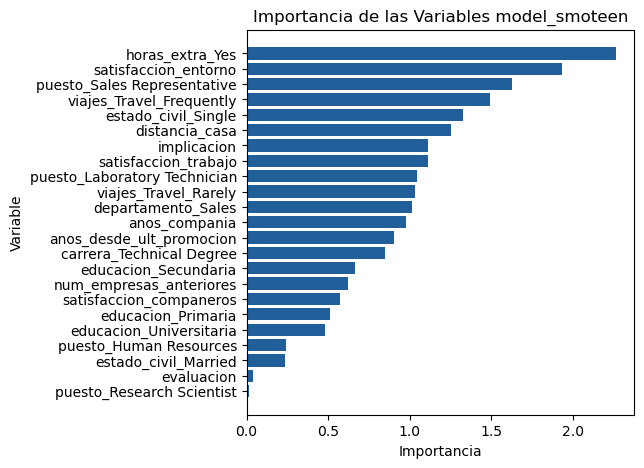

In [220]:
coefficients = model_smoteen.coef_[0]

# Crear un DataFrame para visualizar la importancia de las variables
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': coefficients
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importancia', ascending=False).query('Importancia >=0')

# Visualizar la importancia de las variables usando matplotlib
plt.figure(figsize=(5, 5))
plt.barh(importance_df['Variable'], importance_df['Importancia'], color='#215F9A')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de las Variables model_smoteen')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

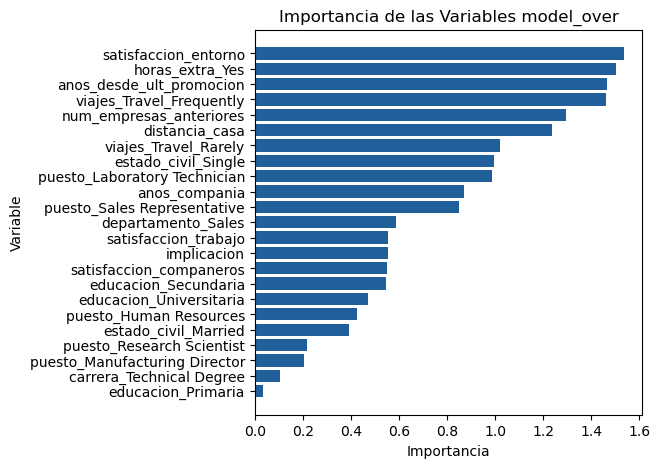

In [221]:
coefficients = model_over.coef_[0]

# Crear un DataFrame para visualizar la importancia de las variables
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': coefficients
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importancia', ascending=False).query('Importancia >=0')

# Visualizar la importancia de las variables usando matplotlib
plt.figure(figsize=(5, 5))
plt.barh(importance_df['Variable'], importance_df['Importancia'], color='#215F9A')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de las Variables model_over')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

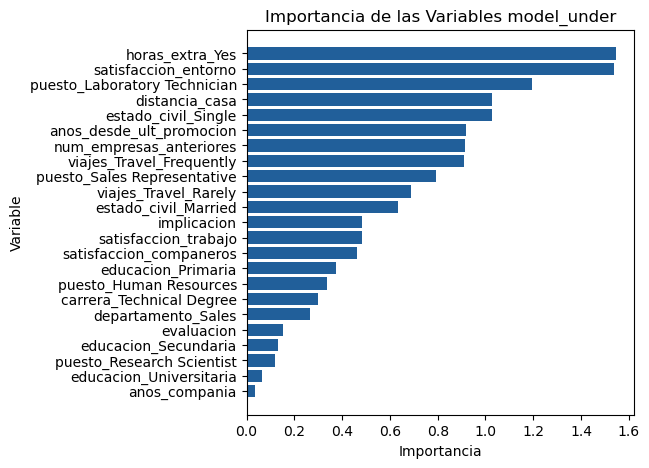

In [222]:
coefficients = model_under.coef_[0]

# Crear un DataFrame para visualizar la importancia de las variables
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': coefficients
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importancia', ascending=False).query('Importancia >=0')

# Visualizar la importancia de las variables usando matplotlib
plt.figure(figsize=(5, 5))
plt.barh(importance_df['Variable'], importance_df['Importancia'], color='#215F9A')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de las Variables model_under')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

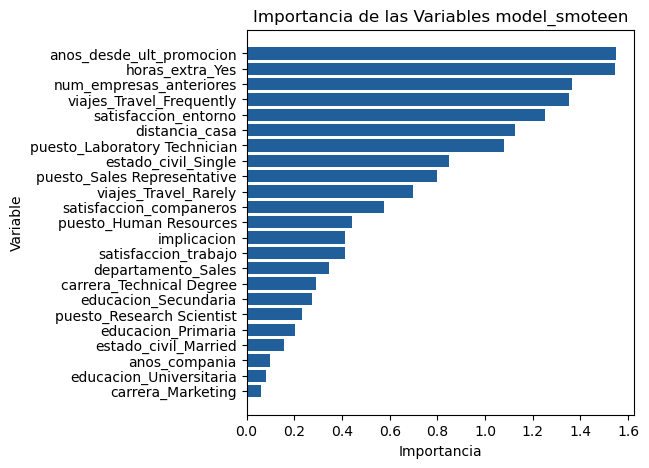

In [223]:
coefficients = model.coef_[0]

# Crear un DataFrame para visualizar la importancia de las variables
importance_df = pd.DataFrame({
    'Variable': X.columns,
    'Importancia': coefficients
})

# Ordenar por importancia
importance_df = importance_df.sort_values(by='Importancia', ascending=False).query('Importancia >=0')

# Visualizar la importancia de las variables usando matplotlib
plt.figure(figsize=(5, 5))
plt.barh(importance_df['Variable'], importance_df['Importancia'], color='#215F9A')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.title('Importancia de las Variables model_smoteen')
plt.gca().invert_yaxis()  # Invertir el eje y para que las variables más importantes estén arriba
plt.show()

* Validando 

### Cross val

In [224]:
# from sklearn.model_selection import cross_val_score

# scores = cross_val_score(model, X_train_scaled_smotee, y_train_smotee, cv=2, scoring='recall')
# print(f"Recall promedio en validación cruzada: {scores.mean()}")

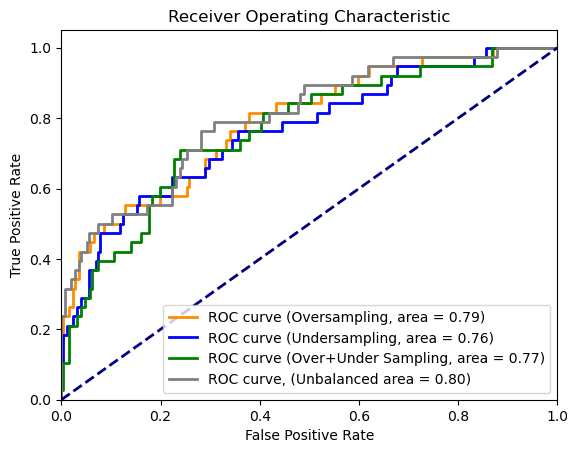

In [226]:
# Supongamos que ya tienes las predicciones para los otros dos modelos
y_pred_over = model_over.predict_proba(X_test_scaled)[:, 1]
y_pred_under = model_under.predict_proba(X_test_scaled)[:, 1]
y_pred_smoteen = model_smoteen.predict_proba(X_test_scaled)[:, 1]
y_pred = model.predict_proba(X_test_scaled)[:, 1]

# Calcula las curvas ROC y AUC para cada modelo
fpr_over, tpr_over, _ = roc_curve(y_test, y_pred_over)
roc_auc_over = roc_auc_score(y_test, y_pred_over)

fpr_under, tpr_under, _ = roc_curve(y_test, y_pred_under)
roc_auc_under = roc_auc_score(y_test, y_pred_under)

fpr_smoteen, tpr_smoteen, _ = roc_curve(y_test, y_pred_smoteen)
roc_auc_smoteen = roc_auc_score(y_test, y_pred_smoteen)


fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)


# Grafica las curvas ROC
plt.figure()
plt.plot(fpr_over, tpr_over, color='darkorange', lw=2, label=f'ROC curve (Oversampling, area = {roc_auc_over:.2f})')
plt.plot(fpr_under, tpr_under, color='blue', lw=2, label=f'ROC curve (Undersampling, area = {roc_auc_under:.2f})')
plt.plot(fpr_smoteen, tpr_smoteen, color='green', lw=2, label=f'ROC curve (Over+Under Sampling, area = {roc_auc_smoteen:.2f})')
plt.plot(fpr, tpr, color='gray', lw=2, label=f'ROC curve, (Unbalanced area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

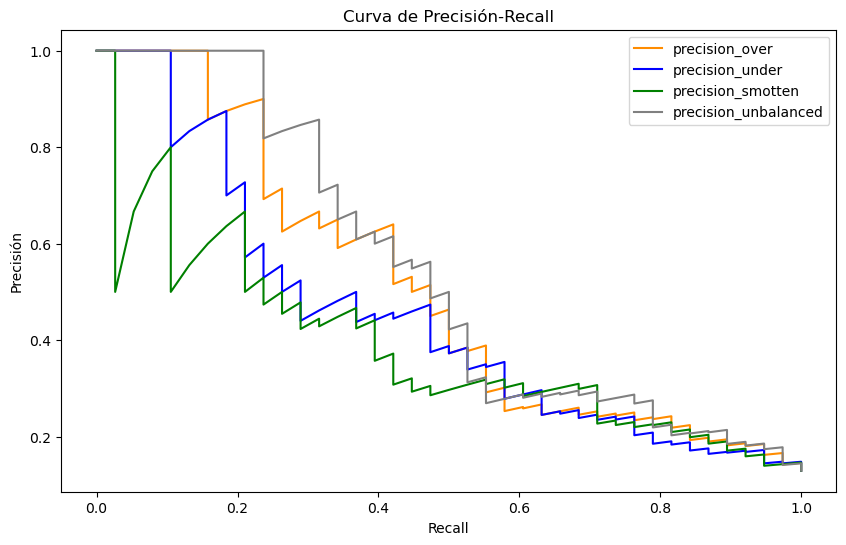

In [227]:
from sklearn.metrics import precision_recall_curve

# Calcular la curva de precisión-recall
precision_over, recall_over, thresholds_over = precision_recall_curve(y_test, y_pred_over)
precision_under, recall_under, thresholds_under = precision_recall_curve(y_test, y_pred_under)
precision_smotten, recall_smoteen, thresholds_smoteen = precision_recall_curve(y_test, y_pred_smoteen)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred)

# Graficar la curva de precisión-recall
plt.figure(figsize=(10, 6))
plt.plot(recall_over, precision_over, color='darkorange', label='precision_over')
plt.plot(recall_under, precision_under,  color='blue',label='precision_under')
plt.plot(recall_smoteen, precision_smotten,  color='green',label='precision_smotten')
plt.plot(recall, precision,   color='gray',label='precision_unbalanced')
plt.xlabel('Recall')
plt.ylabel('Precisión')
plt.title('Curva de Precisión-Recall')
plt.legend(loc="upper right")
plt.show()

In [81]:
from sklearn.model_selection import learning_curve#, StratifiedKFold

/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anamumaq/miniconda3/env

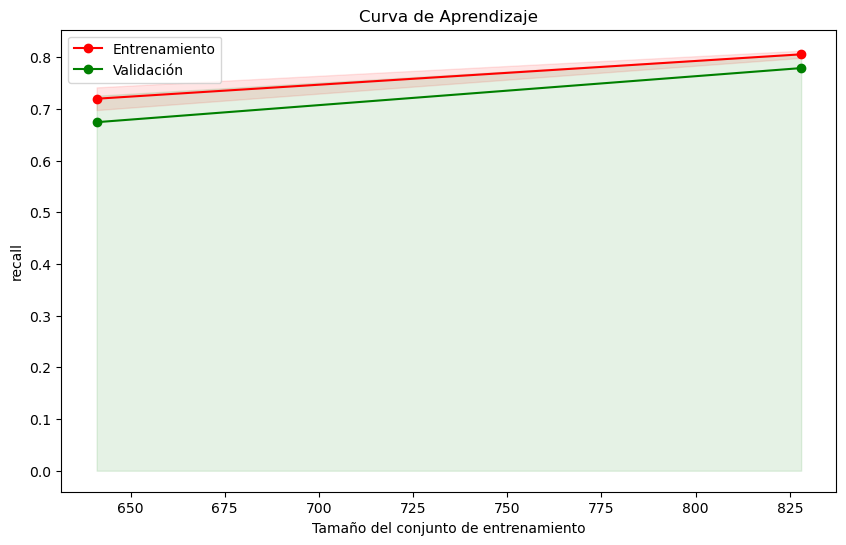

In [228]:

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model_smoteen, X_train_scaled_smotee, y_train_smotee,
                                                        cv=5, scoring='recall', n_jobs=-1)#, error_score='raise')

# Calcular las medias y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validación')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_std - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('recall')
plt.title('Curva de Aprendizaje')
plt.legend(loc='best')
plt.show()

/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


1 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anamumaq/miniconda3/envs/

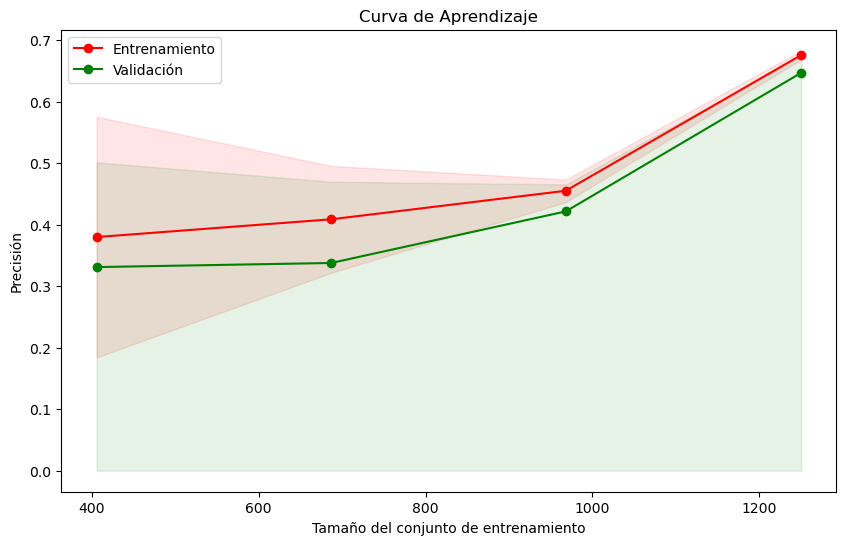

In [229]:

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model_over, X_train_scaled_over, y_train_over,
                                                        cv=5, scoring='recall', n_jobs=-1)#, error_score='raise')

# Calcular las medias y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validación')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_std - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend(loc='best')
plt.show()

/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning:


10 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/anamumaq/miniconda3/envs/proyectos/lib/python3.12/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/anamumaq/miniconda3/env

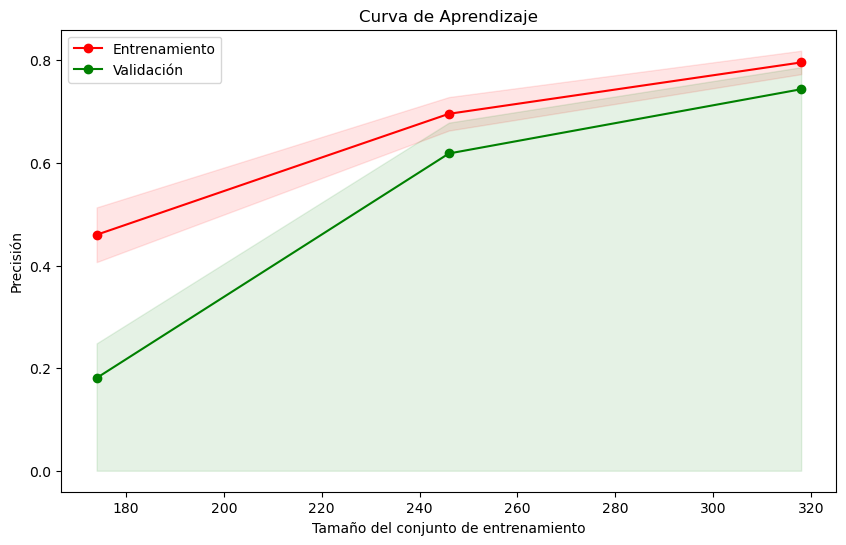

In [230]:

# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model_under, X_train_scaled_under, y_train_under,
                                                        cv=5, scoring='recall', n_jobs=-1)#, error_score='raise')

# Calcular las medias y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validación')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_std - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('Precisión')
plt.title('Curva de Aprendizaje')
plt.legend(loc='best')
plt.show()

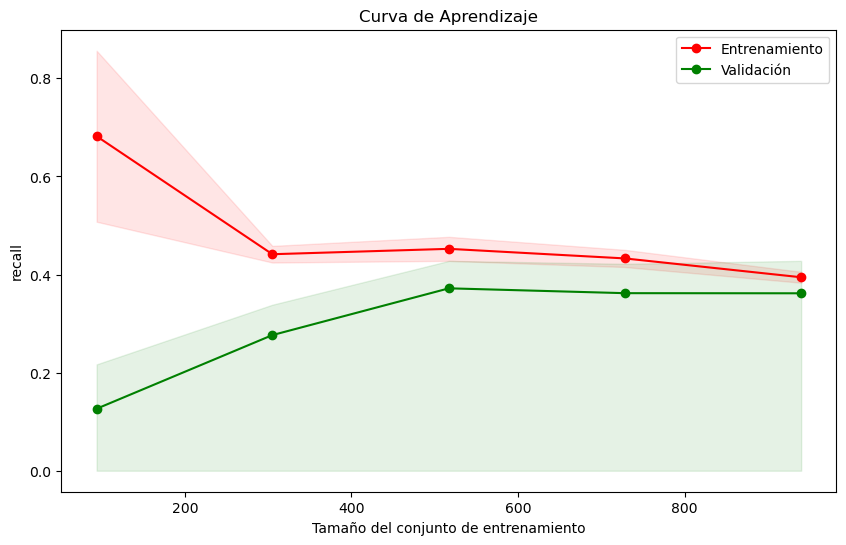

In [231]:
# Calcular la curva de aprendizaje
train_sizes, train_scores, test_scores = learning_curve(model, X_train_scaled, y_train,
                                                        cv=5, scoring='recall', n_jobs=-1)#, error_score='raise')

# Calcular las medias y desviaciones estándar
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)


# Graficar la curva de aprendizaje
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Entrenamiento')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Validación')
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_std - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')
plt.xlabel('Tamaño del conjunto de entrenamiento')
plt.ylabel('recall')
plt.title('Curva de Aprendizaje')
plt.legend(loc='best')
plt.show()